In [16]:
import os
import sys
sys.path.append('..\\..\\')
import pickle
from user_fun.io import read_comsol

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from scipy.interpolate import griddata

xpinn_result_file = '..\\..\\para_result\\heat-x\\test_record.pkl'
udpinn_result_file = '..\\..\\para_result\\heat-ud\\test_record.pkl'
with open(xpinn_result_file, 'rb') as file:
    xpinn_loaded_test_record = pickle.load(file)
with open(udpinn_result_file, 'rb') as file:
    udpinn_loaded_test_record = pickle.load(file)

# 设置字体样式为 Times New Roman
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Times New Roman"
plt.rcParams.update({'font.size': 6})

import numpy as np
from scipy.interpolate import griddata

def interpolate_data(data_points, field_data, num_points_x=100, num_points_y=100):
    x_min, x_max = data_points[:, 0].min(), data_points[:, 0].max()
    y_min, y_max = data_points[:, 1].min(), data_points[:, 1].max()
    x_range = (x_min, x_max)
    y_range = (y_min, y_max)
    
    x_values = np.linspace(x_range[0], x_range[1], num_points_x)
    y_values = np.linspace(y_range[0], y_range[1], num_points_y)
    x_grid, y_grid = np.meshgrid(x_values, y_values)
    grid_points = np.vstack((x_grid.ravel(), y_grid.ravel())).T
    
    field_num = field_data.shape[1] if field_data.ndim > 1 else 1
    
    interpolated_field_data_list = []
    for i in range(field_num):
        cubic_interpolated_field_data = griddata(data_points, field_data[:, i], grid_points, method='cubic')
        nearest_interpolated_field_data = griddata(data_points, field_data[:, i], grid_points, method='nearest')
        
        # Replace NaN values with nearest interpolation results
        interpolated_field_data = np.where(np.isnan(cubic_interpolated_field_data), nearest_interpolated_field_data, cubic_interpolated_field_data)
        
        interpolated_field_data_list.append(interpolated_field_data)
    
    interpolated_field_data = np.stack(interpolated_field_data_list, axis=1)
    return grid_points, interpolated_field_data


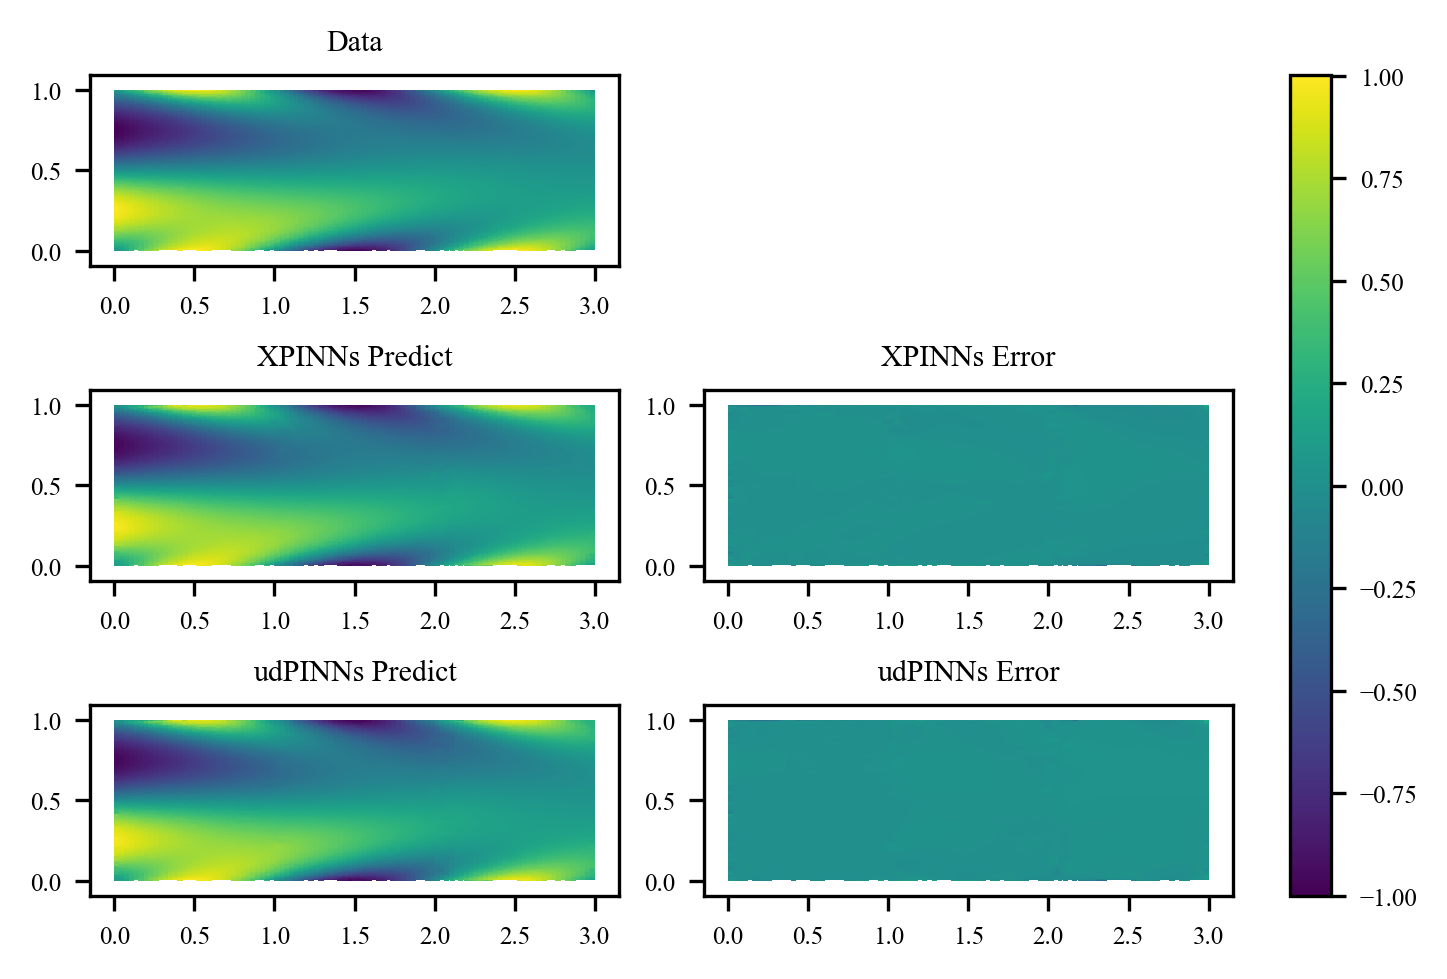

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import os
import sys
sys.path.append('..\\..\\')
import pickle
from user_fun.io import read_comsol
from user_fun.io.read_comsol import process_comsol_time_table
from scipy.interpolate import griddata


# 读取实际的热传导数据
tb = read_comsol.comsol_read('time_heat.csv', skiprows=8)
tb = process_comsol_time_table(tb, space_dimension=1)
x = tb['x'].to_numpy()
t = tb['t'].to_numpy()
u = tb['u (K)'].to_numpy()

# 获取用于插值的网格点
xpinn_points = xpinn_loaded_test_record[99][0]

tb_input = np.column_stack([x,t])
tb_output = u[:,np.newaxis]
ex_tb_input,ex_tb_output = \
    interpolate_data(tb_input, tb_output, num_points_x=300, num_points_y=100)

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri

def plot_actual_predicted(ax, data_points, field_data, title, cmap='viridis', vmin=None, vmax=None):
    x = data_points[:, 1]
    y = data_points[:, 0]
    z = field_data
    triang = tri.Triangulation(x, y)
    im = ax.tripcolor(triang, z.flatten(), cmap=cmap, vmin=vmin, vmax=vmax)  # Flatten the array before plotting
    ax.set_title(title)
    ax.axis('equal')
    return im

def plot_2d_wave_solution(data_points, actual_data, xpinn_result, xpinn_error, udpinn_result, udpinn_error):
    fig, axs = plt.subplots(3, 2,  figsize=(4.72, 3.15), dpi = 300, constrained_layout=True)
    vmin = np.min(actual_data)
    vmax = np.max(actual_data)

    ax1 = axs[0, 0]
    im1 = plot_actual_predicted(ax1, data_points, actual_data, 'Data', vmin=vmin, vmax=vmax)

    ax2 = axs[0, 1]
    ax2.set_axis_off()
    # im2 = plot_actual_predicted(ax2, data_points, xpinn_result, 'Extrapolated output', vmin=vmin, vmax=vmax)

    ax3 = axs[1, 0]
    im3 = plot_actual_predicted(ax3, data_points, xpinn_result, 'XPINNs Predict', vmin=vmin, vmax=vmax)

    ax4 = axs[1, 1]
    im4 = plot_actual_predicted(ax4, data_points, xpinn_error, 'XPINNs Error', vmin=vmin, vmax=vmax)

    ax5 = axs[2, 0]
    im5 = plot_actual_predicted(ax5, data_points, udpinn_result, 'udPINNs Predict', vmin=vmin, vmax=vmax)

    ax6 = axs[2, 1]
    im6 = plot_actual_predicted(ax6, data_points, udpinn_error, 'udPINNs Error', vmin=vmin, vmax=vmax)

    axes = [ax1, ax2, ax3, ax4, ax5, ax6]

    fig.colorbar(im1, ax=axes)
    fig.savefig("heat-1.png", dpi=300, facecolor='white')
    plt.show()

# 假设您已经计算了以下变量: ex_tb_input, ex_tb_output, ex_xpinn_points, actual_data,
# ex_xpinn_field, xpinn_error, ex_udpinn_field, udpinn_error

xpinn_points = xpinn_loaded_test_record[199][0]
xpinn_field = xpinn_loaded_test_record[199][1]
ex_xpinn_points, ex_xpinn_field = interpolate_data(xpinn_points, xpinn_field,
                                                   num_points_x=300)
udpinn_points = udpinn_loaded_test_record[199][0]
udpinn_field = udpinn_loaded_test_record[199][1]
ex_udpinn_points, ex_udpinn_field = interpolate_data(udpinn_points, udpinn_field, num_points_x=300)

plot_2d_wave_solution(ex_xpinn_points, ex_tb_output,
                      ex_xpinn_field, ex_xpinn_field-ex_tb_output,
                      ex_udpinn_field, ex_udpinn_field-ex_tb_output)

(3072, 2)
(96, 2)
(96, 2)
(64, 2)


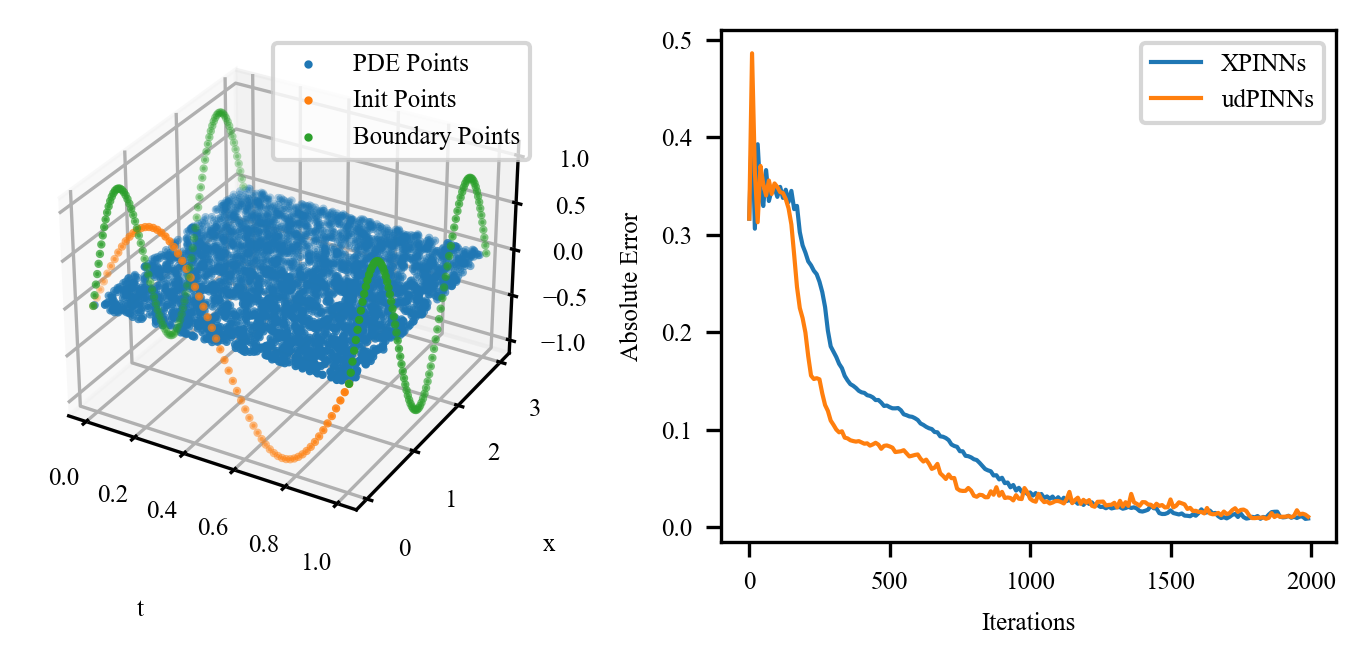

In [18]:
from user_fun.baseline.heat import HeatBenchMark_longtime
cp_list,_ = HeatBenchMark_longtime()
print(cp_list[0][0].shape)
print(cp_list[1][0].shape)
print(cp_list[2][0].shape)
print(cp_list[3][0].shape)
import matplotlib.pyplot as plt

# 假设这些是从HeatBenchMark_longtime获取的数据
# 创建包含左右两个子图的图形
fig = plt.figure(figsize=(4.72, 2.2), dpi=300)

# 左侧子图绘制散点图
# 假设这些是从HeatBenchMark_longtime获取的数据
pde_points = cp_list[0][0]
init_points = cp_list[3][0]
bound_points = np.vstack([cp_list[1][0], cp_list[2][0]])

# 输出值
pde_outputs = cp_list[0][1][:, 0]
init_outputs = cp_list[3][1][:, 0]
bound_outputs = np.hstack([cp_list[1][1][:, 0], cp_list[2][1][:, 0]])

# 创建包含左侧3D子图的图形
ax1 = fig.add_subplot(121, projection='3d')

# 左侧子图绘制3D散点图
ax1.scatter(pde_points[:, 0], pde_points[:, 1], pde_outputs, label='PDE Points', s=1)
ax1.scatter(init_points[:, 0], init_points[:, 1], init_outputs, label='Init Points', s=1)
ax1.scatter(bound_points[:, 0], bound_points[:, 1], bound_outputs, label='Boundary Points', s=1)
ax1.legend()
ax1.set_xlabel('t')
ax1.set_ylabel('x')

ax1.tick_params(axis='x', which='both', pad=0)
ax1.tick_params(axis='y', which='both', pad=0)
ax1.tick_params(axis='z', which='both', pad=0)


ax2 = fig.add_subplot(122)
import numpy as np
import matplotlib.pyplot as plt

def calculate_absolute_error(loaded_test_record, actual_data):
    errors = []
    for i in range(len(loaded_test_record)):
        points = loaded_test_record[i][0]
        pred_field = loaded_test_record[i][1]
        ex_points, ex_field = interpolate_data(points, pred_field, num_points_x=300)
        error = np.abs(ex_field - actual_data)
        errors.append(np.mean(error))
    return errors

def plot_error_vs_iterations(xpinn_errors, udpinn_errors):
    plt.figure(figsize=(8, 6), dpi=300)
    plt.plot(xpinn_errors, label='XPINNs', linewidth=1)
    plt.plot(udpinn_errors, label='udPINNs', linewidth=1)
    plt.xlabel('Iterations')
    plt.ylabel('Absolute Error')
    plt.legend()
    plt.show()

# 计算 XPINNs 和 udPINNs 的绝对误差
xpinn_errors = calculate_absolute_error(xpinn_loaded_test_record, ex_tb_output)
udpinn_errors = calculate_absolute_error(udpinn_loaded_test_record, ex_tb_output)

# 右侧子图绘制误差随训练轮次变化的图
iter = np.arange(0,200,1)*10
ax2.plot(iter, xpinn_errors, label='XPINNs', linewidth=1)
ax2.plot(iter, udpinn_errors, label='udPINNs', linewidth=1)
ax2.set_xlabel('Iterations')
ax2.set_ylabel('Absolute Error')
ax2.legend()


# 调整子图间距
# fig.subplots_adjust()
plt.tight_layout()

# 保存图像
fig.savefig("heat-2.png", dpi=300, facecolor='white')

# 显示图形
plt.show()

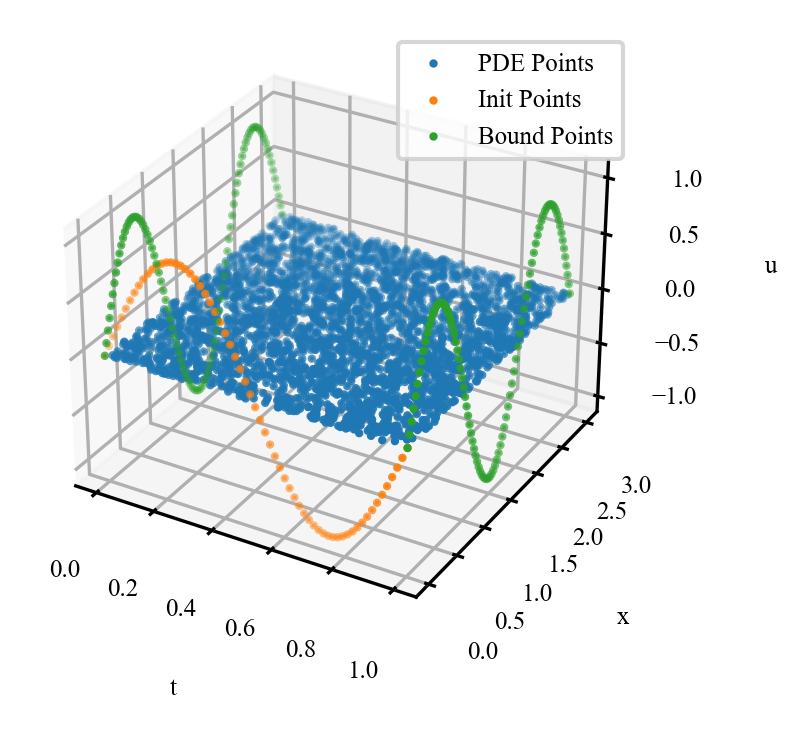

In [19]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
cp_list,_ = HeatBenchMark_longtime()
# 假设这些是从HeatBenchMark_longtime获取的数据
pde_points = cp_list[0][0]
init_points = cp_list[3][0]
bound_points = np.vstack([cp_list[1][0], cp_list[2][0]])

# 输出值
pde_outputs = cp_list[0][1][:, 0]
init_outputs = cp_list[3][1][:, 0]
bound_outputs = np.hstack([cp_list[1][1][:, 0], cp_list[2][1][:, 0]])

# 创建包含左侧3D子图的图形
fig = plt.figure(figsize=(4.72, 2.2), dpi=300)
ax1 = fig.add_subplot(111, projection='3d')

# 左侧子图绘制3D散点图
ax1.scatter(pde_points[:, 0], pde_points[:, 1], pde_outputs, label='PDE Points', s=1)
ax1.scatter(init_points[:, 0], init_points[:, 1], init_outputs, label='Init Points', s=1)
ax1.scatter(bound_points[:, 0], bound_points[:, 1], bound_outputs, label='Bound Points', s=1)
ax1.legend()
ax1.set_xlabel('t')
ax1.set_ylabel('x')
ax1.set_zlabel('u')
plt.tight_layout()

plt.show()

In [20]:
import matplotlib
default_markersize = matplotlib.rcParams['lines.markersize']
print("Default markersize:", default_markersize)

Default markersize: 6.0
